<a href="https://colab.research.google.com/github/mehaase/w266-final-project/blob/main/DATASCI266_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libaries & Data

In [ ]:
!pip install -q transformers

In [ ]:
from google.colab import drive
import json
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

In [ ]:
# Load data from Google Drive
drive.mount('/mnt/gdrive')
project_dir = "/mnt/gdrive/MyDrive/W266 Final Project"
train_df = pd.read_csv(f"{project_dir}/train_df.csv", index_col=0)
test_df = pd.read_csv(f"{project_dir}/test_df.csv", index_col=0)
train_df.head()

Drive already mounted at /mnt/gdrive; to attempt to forcibly remount, call drive.mount("/mnt/gdrive", force_remount=True).


,count,hate_speech,offensive_language,neither,class,tweet,is_hatespeech
0,3,0.000000,0.000000,1.0,2,RT AT_MENTION: How can anyone hate Charlie She...,False
2,3,0.000000,0.000000,1.0,2,RT AT_MENTION: she paid $5 to hold the monkey ...,False
3,3,1.000000,0.000000,0.0,0,RT AT_MENTION: Apartheid. &#8220;AT_MENTION: p...,True
4,3,0.666667,0.333333,0.0,0,AT_MENTION \nShe be what we say in da hood whi...,True
5,3,0.000000,1.000000,0.0,1,Get your nasty ass out of my snapchat bitch,False


# Helper Functions

In [ ]:
def plot_train_test_loss(model_history):
    # Plot training/test loss against epochs
    ymax = max(np.max(model_history.history["loss"]), np.max(model_history.history["val_loss"]))
    plt.plot(model_history.history["loss"])
    plt.plot(model_history.history["val_loss"])
    plt.title("Train/Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0.0, ymax * 1.1)
    plt.legend(["Train", "Test"])
    plt.show()

In [ ]:
def compute_metrics(y_true, y_pred):
    p = tf.keras.metrics.Precision()
    p.update_state(y_true, y_pred)
    precision = p.result()

    r = tf.keras.metrics.Recall()
    r.update_state(y_true, y_pred)
    recall = r.result()

    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

# Training

In [ ]:
PRETRAINED_MODEL = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL, do_lower_case=True)
bert_model = TFBertModel.from_pretrained(PRETRAINED_MODEL)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
MAX_SEQUENCE_LENGTH = 128

X_train = bert_tokenizer(
    train_df.tweet.tolist(),
    max_length=MAX_SEQUENCE_LENGTH,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
)

X_test = bert_tokenizer(
    test_df.tweet.tolist(),
    max_length=MAX_SEQUENCE_LENGTH,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
)

Y_train = train_df.is_hatespeech
Y_test = test_df.is_hatespeech

print("X_train shape:", X_train["input_ids"].shape)
print("X_test  shape:", X_test["input_ids"].shape)

X_train shape: (2288, 128)
X_test  shape: (572, 128)


In [ ]:
# Re-use BERT model from FP_BERT notebook with modifications to output attention tensors.
def build_bert_cls_model(max_sequence_length,
                         hidden_sizes,
                         dropout,
                         learning_rate):
    # Add BERT model
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs, output_attentions=True)
    cls_token = bert_out[0][:, 0, :]
    top_xformer_layer = bert_out[-1][-1]
    cls_token_attentions = tf.keras.layers.Reshape((12, max_sequence_length, max_sequence_length))(top_xformer_layer)[:,:,0,:]

    # Add hidden layers
    dropout_layer = cls_token
    for i, hidden_size in enumerate(hidden_sizes):
        hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', name=f'hidden_layer_{i}')(dropout_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout)(hidden_layer)

    # Add classification layer
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout_layer)

    # Create model
    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[classification, cls_token_attentions]
    )
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=["binary_crossentropy", None],
        metrics=['accuracy'],
    )

    return classification_model

In [ ]:
# Now specify model hyperparameters and call the function to create a BERT model
bert_cls_model = build_bert_cls_model(
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_sizes=[100, 50],
    dropout=0.5,
    learning_rate=0.000005,
)

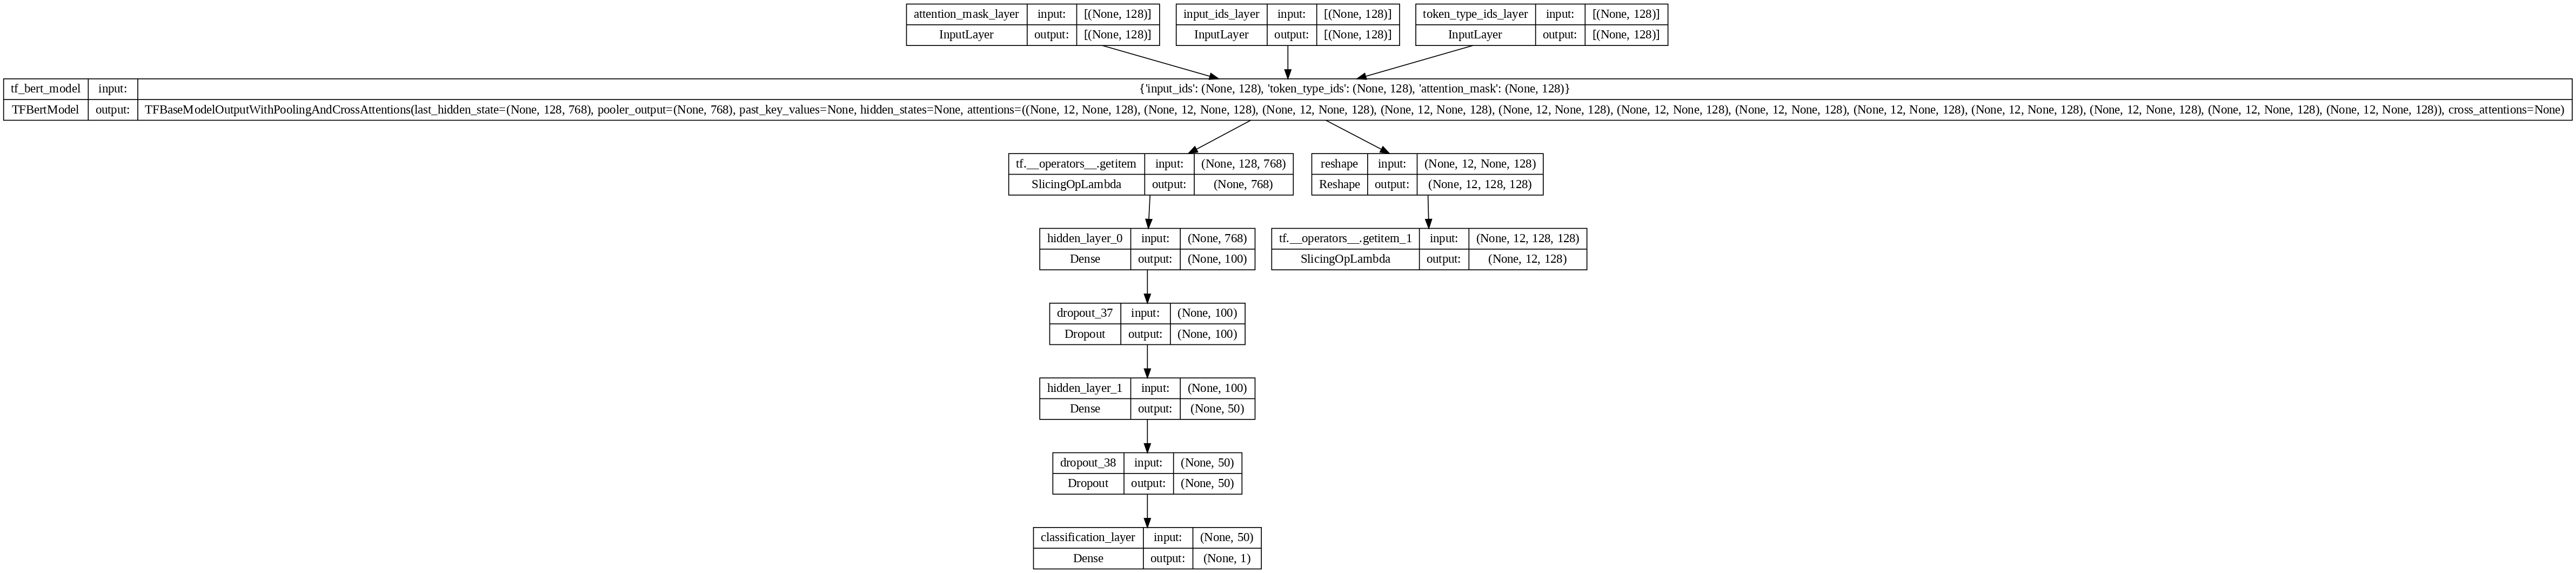

In [ ]:
tf.keras.utils.plot_model(bert_cls_model, show_shapes=True, dpi=120)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_classification_layer_accuracy",
    mode="max",
    save_best_only=True
)

bert_cls_history = bert_cls_model.fit(
    [X_train["input_ids"], X_train["token_type_ids"], X_train["attention_mask"]],
    [Y_train, tf.zeros([Y_train.shape[0],12,128])],
    validation_data=([X_test["input_ids"], X_test["token_type_ids"], X_test["attention_mask"]],
                     [Y_test, tf.zeros([Y_test.shape[0],12,128])]),
    batch_size=32,
    epochs=10,
    callbacks=[checkpoint_callback]
)

bert_cls_model.load_weights(checkpoint_filepath)

Epoch 1/10


72/72 [==============================] - 70s 333ms/step - loss: 0.7227 - classification_layer_loss: 0.7227 - classification_layer_accuracy: 0.5118 - tf.__operators__.getitem_1_accuracy: 0.2147 - val_loss: 0.6784 - val_classification_layer_loss: 0.6784 - val_classification_layer_accuracy: 0.6101 - val_tf.__operators__.getitem_1_accuracy: 0.1563
Epoch 2/10
72/72 [==============================] - 15s 213ms/step - loss: 0.6925 - classification_layer_loss: 0.6925 - classification_layer_accuracy: 0.5310 - tf.__operators__.getitem_1_accuracy: 0.1415 - val_loss: 0.6595 - val_classification_layer_loss: 0.6595 - val_classification_layer_accuracy: 0.6521 - val_tf.__operators__.getitem_1_accuracy: 0.1305
Epoch 3/10
72/72 [==============================] - 16s 220ms/step - loss: 0.6647 - classification_layer_loss: 0.6647 - classification_layer_accuracy: 0.5883 - tf.__operators__.getitem_1_accuracy: 0.1304 - val_loss: 0.6258 - val_classification_layer_loss: 0.6258 - val_classification_layer_accurac

In [ ]:
!mkdir -p {project_dir}/bert_attention/checkpoint

In [ ]:
bert_cls_model.save_weights(f"{project_dir}/bert_attention/checkpoint")

In [ ]:
bert_cls_model.load_weights(f"{project_dir}/bert_attention/checkpoint")

# Evaluation

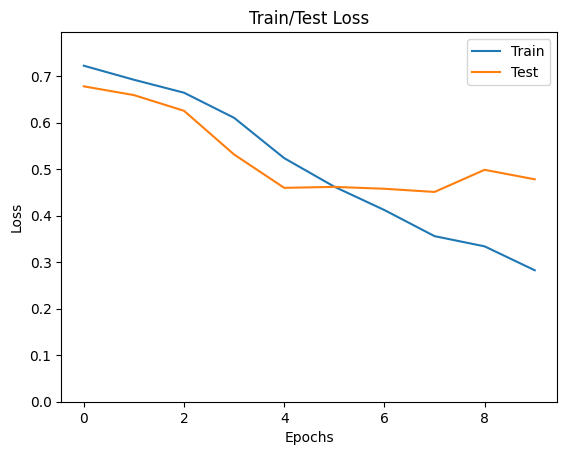

In [ ]:
plot_train_test_loss(bert_cls_history)

In [ ]:
Y_pred, attn = bert_cls_model.predict([X_test["input_ids"], X_test["token_type_ids"], X_test["attention_mask"]])

18/18 [==============================] - 4s 39ms/step


In [ ]:
print("\nTest metrics:")
precision, recall, f1 = compute_metrics(Y_test, Y_pred)
print(f"Precision: {precision:0.4f}")
print(f"Recall:    {recall:0.4f}")
print(f"F1 Score:  {f1:00.4f}")


Test metrics:
Precision: 0.7796
Recall:    0.8714
F1 Score:  0.8229


# Visualize Overall Attention

Extract attention weights for individual tweets and visualize the weights for the [CLS] token to attend to all other tokens. Since there are 12 attention heads in BERT, we combine 12 attention vectors into a single 128d vector -- we experiment with a few approaches for how to combine.

In [ ]:
def get_token_attentions(row, reduce_attn_callback):
    tokens = bert_tokenizer(
        [row.tweet],
        max_length=MAX_SEQUENCE_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
    )
    detokens = bert_tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])
    max_idx = detokens.index("[SEP]")
    tokens_slice = detokens[1:max_idx]
    pred, attn = bert_cls_model.predict([tokens["input_ids"], tokens["token_type_ids"], tokens["attention_mask"]], verbose=False)
    attn_slice = attn.reshape(12, MAX_SEQUENCE_LENGTH)[:, 1:max_idx]
    attn_sum = reduce_attn_callback(attn_slice)
    token_attn = list(zip(tokens_slice, attn_sum.numpy()))
    return token_attn

In [ ]:
# A few different options for combining 12 attention heads into a single attention score
def reduce_attn_sum(attn_slice):
    return tf.linalg.normalize(tf.math.reduce_sum(attn_slice, 0))[0]

def reduce_attn_prod(attn_slice):
    return tf.linalg.normalize(tf.math.reduce_prod(attn_slice, 0))[0]

def reduce_attn_max(attn_slice):
    return tf.linalg.normalize(tf.math.reduce_max(attn_slice, 0))[0]

In [ ]:
def visualize_attention(is_hatespeech, attn):
    html = "<p style='font-size: 12pt; line-height: 2'>\n"
    if is_hatespeech:
        html += f"<span style='padding: 3px; background-color: #ff9900'>Label: Hate Speech</span>\n"
    else:
        html += f"<span style='padding: 3px; background-color: #00cc99'>Label: Not Hate Speech</span>\n"
    for token, score in attn:
        color = int((1-score) * 255)
        html += f"<span style='padding: 3px; background-color: #ff{color:02x}{color:02x}'>{token}</span>\n"
    html += "</p>\n"
    return HTML(html)

In [ ]:
def test_row_all(n):
    row = test_df.iloc[n]
    print("Using sum:")
    token_attn = get_token_attentions(row, reduce_attn_sum)
    display(visualize_attention(row.is_hatespeech, token_attn))
    print("Using product:")
    token_attn = get_token_attentions(row, reduce_attn_prod)
    display(visualize_attention(row.is_hatespeech, token_attn))
    print("Using max:")
    token_attn = get_token_attentions(row, reduce_attn_max)
    display(visualize_attention(row.is_hatespeech, token_attn))

In [ ]:
test_row_all(16)

Using sum:
1/1 [==============================] - 0s 42ms/step
(28,)


Using product:
1/1 [==============================] - 0s 43ms/step
(28,)


Using max:
1/1 [==============================] - 0s 42ms/step
(28,)


In [ ]:
test_row_all(17)

Using sum:
1/1 [==============================] - 0s 41ms/step
(30,)


Using product:
1/1 [==============================] - 0s 41ms/step
(30,)


Using max:
1/1 [==============================] - 0s 39ms/step
(30,)


In [ ]:
test_row_all(18)

Using sum:
1/1 [==============================] - 0s 46ms/step
(40,)


Using product:
1/1 [==============================] - 0s 40ms/step
(40,)


Using max:
1/1 [==============================] - 0s 40ms/step
(40,)


In [ ]:
test_row_all(20)

Using sum:
1/1 [==============================] - 0s 41ms/step
(14,)


Using product:
1/1 [==============================] - 0s 40ms/step
(14,)


Using max:
1/1 [==============================] - 0s 41ms/step
(14,)


The sum approach provides best explanation for both positive and negative cases.

In [ ]:
test_row_all(33)

Using sum:
1/1 [==============================] - 0s 43ms/step
(21,)


Using product:
1/1 [==============================] - 0s 41ms/step
(21,)


Using max:
1/1 [==============================] - 0s 41ms/step
(21,)


In [ ]:
test_row_all(37)

Using sum:
1/1 [==============================] - 0s 39ms/step
(31,)


Using product:
1/1 [==============================] - 0s 42ms/step
(31,)


Using max:
1/1 [==============================] - 0s 43ms/step
(31,)


In [ ]:
test_row_all(43)

Using sum:
1/1 [==============================] - 0s 41ms/step
(25,)


Using product:
1/1 [==============================] - 0s 42ms/step
(25,)


Using max:
1/1 [==============================] - 0s 42ms/step
(25,)


In [ ]:
test_row_all(69)

Using sum:
1/1 [==============================] - 0s 42ms/step
(18,)


Using product:
1/1 [==============================] - 0s 42ms/step
(18,)


Using max:
1/1 [==============================] - 0s 41ms/step
(18,)


# Visualize Attention Heads

In the previous section, the attention weights were aggregated over all of the attention heads to produce a single score for each token. In this section we quickly look at each attention head separately to see what kinds of features each head is learning.

In [ ]:
def get_token_attentions_per_head(row):
    """ Same as get_token_attentions but with no reduce step, i.e. instead of returning
    1x128 tensor, return 12x128 tensor so that we get all attention heads. """
    tokens = bert_tokenizer(
        [row.tweet],
        max_length=MAX_SEQUENCE_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
    )
    detokens = bert_tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])
    max_idx = detokens.index("[SEP]")
    tokens_slice = detokens[1:max_idx]
    pred, attn = bert_cls_model.predict([tokens["input_ids"], tokens["token_type_ids"], tokens["attention_mask"]], verbose=False)
    attn_slice = attn.reshape(12, MAX_SEQUENCE_LENGTH)[:, 1:max_idx]
    heads = list()
    for i in range(12):
        heads.append(list(zip(tokens_slice, attn_slice[i,:])))
    return heads

In [ ]:
def test_row_attn_heads(n):
    row = test_df.iloc[n]
    token_attns = get_token_attentions_per_head(row)
    for i, token_attn in enumerate(token_attns):
      print(f"Head #{i}:")
      display(visualize_attention(row.is_hatespeech, token_attn))

In [ ]:
test_row_attn_heads(70)

Head #0:


Head #1:


Head #2:


Head #3:


Head #4:


Head #5:


Head #6:


Head #7:


Head #8:


Head #9:


Head #10:


Head #11:


In [ ]:
test_row_attn_heads(85)

Head #0:


Head #1:


Head #2:


Head #3:


Head #4:


Head #5:


Head #6:


Head #7:


Head #8:


Head #9:


Head #10:


Head #11:


In [ ]:
test_row_attn_heads(87)

Head #0:


Head #1:


Head #2:


Head #3:


Head #4:


Head #5:


Head #6:


Head #7:


Head #8:


Head #9:


Head #10:


Head #11:


Individual attention heads aren't that interesting. Most heads seem to focus on similar things, especially perjorative terms. (This may be more heads than is needed for this task.) Notable that a couple heads focus on the verb "are".

# Evaluating Attention

Create a dataset that contains 100 examples of hatespeech annotated with the offensive terms in each example.

In [ ]:
sample = test_df[test_df.is_hatespeech].sample(n=5)
sample

,count,hate_speech,offensive_language,neither,class,tweet,is_hatespeech
1058,3,0.666667,0.333333,0.000000,0,RT AT_MENTION: Happy birthday freshman faggots...,True
686,3,0.666667,0.000000,0.333333,0,AT_MENTION But that's what you call white tras...,True
1735,3,0.666667,0.333333,0.000000,0,AT_MENTION AT_MENTION fucking gay faggot look ...,True
2858,3,0.666667,0.333333,0.000000,0,"""We're out here, and we're queer!""\n"" 2, 4, 6,...",True
376,3,0.666667,0.333333,0.000000,0,#California is full of white trash who moved f...,True


In [ ]:
def make_attn_eval_set(size):
    """ Sample 100 hate speech tweets and get their tokens """
    sample = test_df[test_df.is_hatespeech].sample(n=size)
    detokens = dict()
    for row in sample.itertuples():
        tokens =  bert_tokenizer(
            [row.tweet],
            max_length=MAX_SEQUENCE_LENGTH,
            truncation=True,
            padding='max_length',
            return_tensors='tf',
        )["input_ids"]
        d = bert_tokenizer.convert_ids_to_tokens(tokens[0])
        max_idx = d.index("[SEP]")
        detokens[row.Index] = d[1:max_idx]
    return detokens

In [ ]:
attn_eval = make_attn_eval_set(size=100)

In [ ]:
with open(f"{project_dir}/attn_eval.json", "w") as f:
    json.dump(attn_eval, f, indent=2)

We labeled the attn_eval set offline and then copied it back onto google drive so we can load it into a notebook.

In [ ]:
with open(f"{project_dir}/attn_eval_candidates.json") as f:
    attn_eval_candidates = json.load(f)

In [ ]:
# Contains candidate phrases for each of the hate speech tweets in the sample. We can use this to run ROUGE-1.
attn_eval_candidates["1476"]

['white', 'trash']

In [ ]:
# This is the corresponding row in the data frame showing the original text. We selected
# a candidate set of words that are most indicative of hate speech.
test_df.loc[1476]

count                                                  3
hate_speech                                          1.0
offensive_language                                   0.0
neither                                              0.0
class                                                  0
tweet                 #California is full of white trash
is_hatespeech                                       True
Name: 1476, dtype: object

In [ ]:
!pip install -q keras-nlp rouge-score

In [ ]:
import keras_nlp

Using TensorFlow backend


In [ ]:
y_true = "helo world"
y_pred = "goodbye peeps"

rouge1 = keras_nlp.metrics.RougeL()
rouge1(y_true, y_pred)

{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [ ]:
y_true = "white"
y_pred = "white trash"

rouge1 = keras_nlp.metrics.RougeL()
rouge1(y_true, y_pred)

{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.5>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.6666667>}

In [ ]:
def run_rouge(attn_eval_candidates, token_attns, attn_thresh):
    """ Run ROUGE analysis for the 100 tweets sampled from the is_hatespeech class. """
    references = list()
    candidates = list()

    for idx, candidate in attn_eval_candidates.items():
        # Create the reference:
        token_attn = token_attns[idx]
        references.append(" ".join(
            token for token, score in token_attn if score > attn_thresh
        ))

        # Create the candidate
        candidates.append(" ".join(candidate))

    print("Showing first 5 references and candidates")
    for i in range(5):
        print(f"{i}: {references[i]} -- {candidates[i]}")

    rouge1 = keras_nlp.metrics.RougeL()
    f1 = rouge1(candidates, references)["f1_score"]
    print(f"ROUGE-1 score: {f1:0.4f}")
    return f1

In [ ]:
def get_eval_token_attns(attn_eval_candidates):
    """ Get token attentions for each item in the eval set. """
    token_attns = {}
    for idx, candidate in attn_eval_candidates.items():
        row = test_df.loc[int(idx)]
        token_attns[idx] = get_token_attentions(row, reduce_attn_sum)
    return token_attns

In [ ]:
%%time
eval_token_attns = get_eval_token_attns(attn_eval_candidates)

CPU times: user 19.9 s, sys: 564 ms, total: 20.5 s
Wall time: 24.8 s


In [ ]:
f1 = run_rouge(attn_eval_candidates, eval_token_attns, attn_thresh=0.5)

Showing first 5 references and candidates
0: white -- white trash
1: hate fat -- hate fat bitch ##es
2: fa ##gg -- fa ##gg ##ot
3: dyke -- dyke bitch ##es kill ho ##es
4: fa ##gg -- fa ##gg ##ots
ROUGE-1 score: 0.3616


In [ ]:
def grid_search_attn_thresh(start, end, step):
    best_t, best_f1 = -1, -1
    """ Grid search over attention thresholds to find the one with best ROUGE score. """
    t = start
    while t <= end:
        print(f"threshold={t}")
        f1 = run_rouge(attn_eval_candidates, eval_token_attns, t)
        if f1 > best_f1:
          best_t, best_f1 = t, f1
        t += step
    print(f"best f1={best_f1} at t={best_t}")

In [ ]:
%%time
grid_search_attn_thresh(0, 1, 0.1)

threshold=0
Showing first 5 references and candidates
0: # california is full of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: rt at _ mention : at _ mention at _ mention joshua is a fa ##gg ##ot . just suspend him on those grounds -- fa ##gg ##ot
3: dyke bitch ##es kill me think ##in they really got ho ##es lo ##l -- dyke bitch ##es kill ho ##es
4: rt at _ mention : happy birthday freshman fa ##gg ##ots at _ mention at _ mention -- fa ##gg ##ots
ROUGE-1 score: 0.4082
threshold=0.1
Showing first 5 references and candidates
0: # california is full of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: rt joshua is a fa ##gg ##ot . him -- fa ##gg ##ot
3: dyke bitch ##es kill they got ho ##es lo ##l -- dyke bitch ##es kill ho ##es
4: freshman fa ##gg ##ots -- fa ##gg ##ots
ROUGE-1 score: 0.5839
threshold=0.2
Showing first 5 references and candidates
0: of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2:

In [ ]:
%%time
grid_search_attn_thresh(0.15, 0.25, 0.01)

threshold=0.15
Showing first 5 references and candidates
0: # california is of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: joshua is a fa ##gg ##ot . -- fa ##gg ##ot
3: dyke bitch ##es got ho ##es ##l -- dyke bitch ##es kill ho ##es
4: freshman fa ##gg ##ots -- fa ##gg ##ots
ROUGE-1 score: 0.6441
threshold=0.16
Showing first 5 references and candidates
0: # california is of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: joshua is a fa ##gg ##ot -- fa ##gg ##ot
3: dyke bitch ##es got ho ##es ##l -- dyke bitch ##es kill ho ##es
4: freshman fa ##gg ##ots -- fa ##gg ##ots
ROUGE-1 score: 0.6538
threshold=0.17
Showing first 5 references and candidates
0: # of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: joshua is a fa ##gg ##ot -- fa ##gg ##ot
3: dyke bitch ##es ho ##es ##l -- dyke bitch ##es kill ho ##es
4: freshman fa ##gg ##ots -- fa ##gg ##ots
ROUGE-1 score: 0.6539
threshold=0.18000000000000

The best ROUGE score is 0.6576 when the attn threshold is set to 0.18.